# 4章 4.2 EGM を用いた TI の準コード（$\delta = 1.0$）

In [1]:
# パッケージのインポート

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import leastsq
import numpy as np
from numpy.polynomial.chebyshev import Chebyshev

### 1. パラメータをカリブレーション

In [2]:
# パラメータをカリブレーション
beta = 0.96
gamma = 1.0
alpha = 0.4
delta = 1.0

### 2. 収束の基準を定義

In [3]:
# 収束の基準を定義
epsilon = 1e-5

### 3. 制御変数のグリッドを生成

- $\{ k^\prime \}_{i = 1}^N, \;\; N = 21$
- $k_1^\prime = 0, k_{21}^\prime = 0.5$

In [4]:
# 制御変数のグリッドを生成
kprime_grid = np.linspace(0.025, 0.5, 20)
print(kprime_grid)

[0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3
 0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5  ]


### 4. $k_i^\prime$ に対応する $c_i^\prime$ を当て推量する

- 政策関数 $c_i^\prime = h^{(0)}(k^\prime)$
- 初期値は次期の資本 $k^\prime$ のグリッド * 0.8の値とする

In [5]:
# 政策関数の初期値を当て推量
h_old_discrete = kprime_grid * 0.8
print(h_old_discrete)

[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4 ]


### 5. 古い政策関数 $h^{(n-1)}(k^\prime)$ を所与として，各 $k_i^\prime$ について ($c_i,\;k_i$)の組を求める

  - $c_i = u^{\prime -1}(\beta u^\prime(h(k_i^\prime))\tilde{f}(k_i^\prime))$ から，$c_i$ を得る
  - 求めた$c_i$ と $c_i + k_i^\prime = \tilde{f}(k_i) \Rightarrow k_i = \tilde{f}^{-1}(c_i + k_i^\prime)$ から$k_i$ を得る

In [135]:
# 5. 古い政策関数を所与として，各グリッドについて今期の消費と貯蓄の組を求める
def compute_h_new_discrete(h_old_discrete: npt.NDArray[np.float64], 
                            kprime_grid: npt.NDArray[np.float64]
                            ):
    # 求める政策関数の値を格納する配列
    c_grid = np.zeros_like(kprime_grid)
    k_grid = np.zeros_like(kprime_grid)

    # 計算で使用する関数を定義
    def mu_reverse(mu: float): # 限界効用関数の逆関数
        return 1.0 / mu
    def mu(c: float): # 限界効用関数
        return 1.0 / c
    def mf_tilde(k: float): # 限界生産関数
        return alpha * k ** (alpha - 1)
    def f_tilde_reverse(f_tilde: float): # 生産関数の逆関数
        return f_tilde ** (1 / alpha)
    
    # 各グリッドについて今期の消費と貯蓄の組を求める
    for i, kprime in enumerate(kprime_grid):
        
        cprime = h_old_discrete[i] 
        c_grid[i] = mu_reverse(beta * mu(cprime) * mf_tilde(kprime))
        k_grid[i] = f_tilde_reverse(c_grid[i] + kprime)

    return c_grid, k_grid

### 6. チェビシェフ多項式を用いて補間することで，連続な新しい政策関数を得る

In [159]:
# 6. 新しい政策関数を表す消費と貯蓄の組みの配列をチェビシェフ多項式を
# 用いて補間することで，連続な新しい政策関数 c = h^(n)(k) を得る

def compute_h_new_continuous(c_grid, k_grid):
    # k_gridに対してチェビシェフ多項式のフィッティングを行う
    cheb_fit = Chebyshev.fit(k_grid, c_grid, deg=16) # 次数は適当に10とした
    
    # 新しいkの入力に対して連続的な政策関数h^(n)(k)を評価する関数を返す
    def h_new(k):
        return cheb_fit(k)
    
    return h_new


### $6^\prime$ スプライン補間を用いて補間することで，連続な新しい政策関数を得る

In [137]:
from scipy.interpolate import interp1d

def sp_compute_h_new_continuous(c_grid, k_grid):
    # 線形補間を使用
    interpolator = interp1d(k_grid, c_grid, kind='cubic')
    
    def h_new(k):
        return interpolator(k)
    
    return h_new


### 7. 新しい政策関数と古い政策関数を比較し収束を判定, 収束しない場合は 5,6を繰り返す

In [160]:
diff = 1e-5 + 1.0
loop = 0
h_old_discrete = kprime_grid
while diff > epsilon:
    loop += 1
    print(f"loop: {loop}")
    
    # 5. 古い政策関数を所与として，各グリッドについて今期の消費と貯蓄の組を求める
    c_grid, k_grid = compute_h_new_discrete(h_old_discrete, kprime_grid)
    # print("c_grid: ", c_grid)
    # print("k_grid: ", k_grid)

    # 6. 新しい政策関数を表す消費と貯蓄の組みの配列をチェビシェフ多項式を
    # 用いて補間することで，連続な新しい政策関数 c = h^(n)(k) を得る
    h_new_continuous = compute_h_new_continuous(c_grid, k_grid)

    np_h_new_continuous = np.frompyfunc(h_new_continuous, 1, 1)
    
    # 7. 収束の基準を満たしているか確認
    # cprime_grid = np_h_new_continuous(kprime_grid)
    # print(f"cprime_grid: {cprime_grid}")
    diffs = h_old_discrete - np_h_new_continuous(kprime_grid)
    abc_diffs = np.abs(diffs)
    diff = np.max(abc_diffs)
    print(f"diff: {diff}")
    h_old_discrete = h_new_continuous(kprime_grid)

loop: 1
diff: 0.21416628062725068
loop: 2
diff: 0.6138398256152868
loop: 3
diff: 36.3693544305861
loop: 4
diff: 35.957133028656244
loop: 5
diff: 0.032903959724876586
loop: 6
diff: 0.009589350666942664
loop: 7
diff: 0.0040241066019746086
loop: 8
diff: 0.0015077042745019753
loop: 9
diff: 0.0005166986489655301
loop: 10
diff: 0.000177063791738874
loop: 11
diff: 6.27045623673439e-05
loop: 12
diff: 2.279802993143676e-05
loop: 13
diff: 8.400536671615555e-06


/Users/hiroetomokana/Library/Caches/pypoetry/virtualenvs/quant-macro-workshop-bUjjWVNQ-py3.12/lib/python3.12/site-packages/numpy/polynomial/chebyshev.py:1671: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)
/Users/hiroetomokana/Library/Caches/pypoetry/virtualenvs/quant-macro-workshop-bUjjWVNQ-py3.12/lib/python3.12/site-packages/numpy/polynomial/chebyshev.py:1671: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


In [129]:
# %reset -f

In [161]:
print(loop)
print(h_old_discrete)

13
[0.1435989  0.18529991 0.21708944 0.24567856 0.26931548 0.28833038
 0.30493377 0.32110336 0.33748691 0.35356701 0.36844396 0.38157395
 0.39309954 0.40373002 0.41434021 0.42552984 0.43734704 0.44927741
 0.46048417 0.47019258]


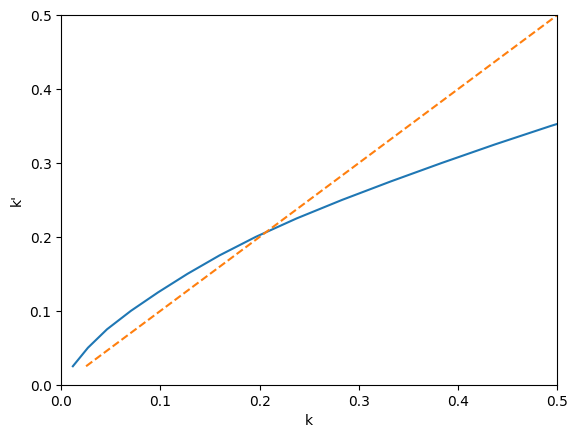

In [163]:
# k_gridを横軸にkprime_gridを縦軸にプロット, ラベルもつける, 45度線を引く. 縦軸の上限を0.5にする
k_grid =  (h_old_discrete + kprime_grid) ** (1 / alpha) 
plt.plot(k_grid, kprime_grid)
plt.plot(kprime_grid, kprime_grid, linestyle="--")
plt.xlabel("k")
plt.ylabel("k'")
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.show()